In [1]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import infer
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pylab as plt
import warnings
from numpyro.contrib.nested_sampling import NestedSampler #Need to have jaxns v 1.1.2 or earlier for this to work
warnings.filterwarnings("ignore", category=FutureWarning)
numpyro.set_host_device_count(1)
jax.config.update('jax_platform_name', 'cpu')

/home/hughmc/anaconda3/envs/nestconda_dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO[2023-03-20 13:45:13,372]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2023-03-20 13:45:13,374]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-03-20 13:45:13,375]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-03-20 13:45:13,379]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO[2023-03-20 13:45:13,380]: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugi

In [2]:
def potential(x,y):
    x_width = 30
    y_width = 60

    out = 0
    for i in [0,1]:
        for j in [0,1]:
            dx = x - (180 + 360*i)
            dy = y - (180 + 360*j)
            r2 = (dx/x_width)**2 + (dy/y_width)**2
            
            if i == 1 and j==1: 
                out += jnp.exp(-r2/2) * 2
            else: 
                out += jnp.exp(-r2/2) 

    return(out)

def model():

    x = numpyro.sample('x', numpyro.distributions.Uniform(0,800))
    y = numpyro.sample('y', numpyro.distributions.Uniform(0,800))

    numpyro.factor('log_pot', jnp.log( potential(x,y) + 1E-15 ) ) #Add buffer to avoid log-zero issues which mess with some samplers

In [3]:
#Create a nested sampler from the model. This is acts as both the MCMC object and the sampling kernel
ns = NestedSampler(model, constructor_kwargs={"num_live_points":50*4*(2+1), "max_samples":50*4*(2+1)*2})

print("Starting Sampling")
ns.run(jax.random.PRNGKey(1))
print("Sampling Done")

Starting Sampling
Sampling Done


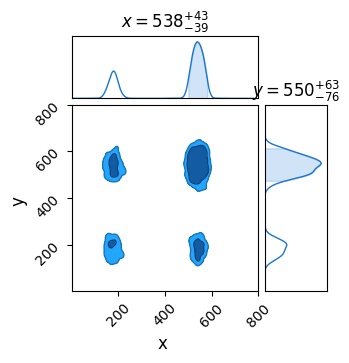

In [4]:
c_nest = ChainConsumer()

nest_out = ns.get_samples(jax.random.PRNGKey(1),10000)

c_nest.add_chain([nest_out['x'],nest_out['y']], parameters=['x','y'])
c_nest.plotter.plot(extents={"x": (0,800), "y": (0,800)})

plt.show()

In [5]:
nburn    = 0
nchains  = 300
nsamples = 100

start_positions = ns.get_samples(jax.random.PRNGKey(0),nchains)

#--------
#Perform some strange NumPyro Magic
from numpyro.infer.util import transform_fn
transforms = {"x": numpyro.distributions.biject_to(numpyro.distributions.Uniform(0, 800).support),
              "y": numpyro.distributions.biject_to(numpyro.distributions.Uniform(0, 800).support)}
params = transform_fn(transforms, start_positions, invert=True)
#--------

print("Beginning sampling...")
sampler = numpyro.infer.MCMC(
    infer.NUTS(model = model),
    num_warmup=nburn,
    num_samples=nsamples,
    num_chains=nchains,
    progress_bar=False,
    chain_method = 'sequential',
)

sampler.run(jax.random.PRNGKey(0), init_params=params)
output=sampler.get_samples()
print("Done")

Beginning sampling...
Done


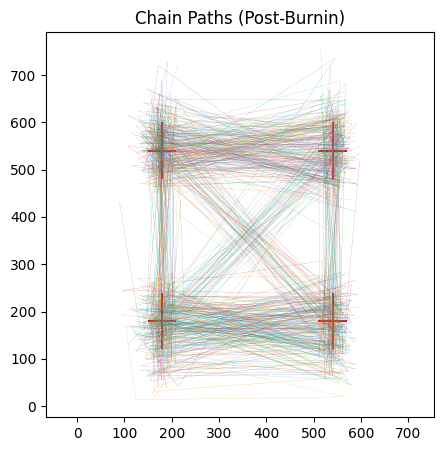

WARNING[2023-03-20 13:46:47,438]: Parameter x in chain Chain 0 is not constrained
WARNING[2023-03-20 13:46:47,475]: Parameter y in chain Chain 0 is not constrained


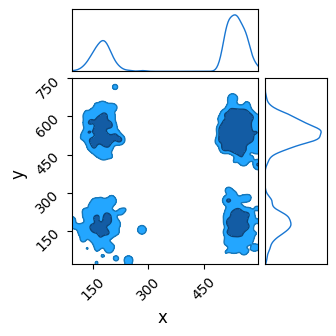

In [6]:
plt.figure(figsize=(5,5))
plt.title("Chain Paths (Post-Burnin)")
plt.axis('equal')
plt.errorbar([180,180*3,180*3,180],[180*3,180*3,180,180],yerr=60, xerr= 30, fmt='none', c='r')
for i in range(nchains):
    plt.plot(output['x'][i*nsamples:(i+1)*nsamples],output['y'][i*nsamples:(i+1)*nsamples],lw=0.1)
plt.show()

c= ChainConsumer()
c.add_chain([output['x'],output['y']], parameters=['x','y'])
c.plotter.plot()
plt.show()
